In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.1 MB/s eta 0:00:00


In [2]:
import timm
import os

import matplotlib.pyplot as plt
import PIL
from PIL import Image
import json

import torch
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

from fastai.vision.all import *

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


Použijeme ConvNeXt model a Chest X-Ray Images (Pneumonia) dataset na klasifikaci, fine-tuning a dat augmentation.

In [4]:
model_name = "convnext_tiny.fb_in22k"
convnext = timm.create_model(model_name, pretrained=True).to(device)

In [5]:
!wget https://dl.fbaipublicfiles.com/convnext/label_to_words.json
imagenet_labels = json.load(open('label_to_words.json'))

--2023-10-08 08:58:09--  https://dl.fbaipublicfiles.com/convnext/label_to_words.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.59, 13.227.219.70, 13.227.219.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 773945 (756K) [application/json]
Saving to: ‘label_to_words.json’

label_to_words.json 100%[===================>] 755.81K  --.-KB/s    in 0.02s   

2023-10-08 08:58:09 (32.4 MB/s) - ‘label_to_words.json’ saved [773945/773945]



 **Chest X-Ray Images**


In [9]:
DATASET = 'paultimothymooney/chest-xray-pneumonia'
ZIP_PATH = './chest-xray-pneumonia.zip'
IMAGES_PATH = './chest_xray/chest_xray'


In [7]:
os.environ['KAGGLE_USERNAME'] = 'tompetit'
os.environ['KAGGLE_KEY'] = '547c06c5f00da137d8f626ef0290097d'

!kaggle datasets download -d {DATASET} -p ./

100% 2.29G/2.29G [01:02<00:00, 40.9MB/s]
100% 2.29G/2.29G [01:02<00:00, 39.5MB/s]


In [8]:
import zipfile

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall('./')

In [10]:
image_files = get_image_files(Path(IMAGES_PATH))
print(image_files)

[Path('chest_xray/chest_xray/test/PNEUMONIA/person1650_virus_2852.jpeg'), Path('chest_xray/chest_xray/test/PNEUMONIA/person112_bacteria_538.jpeg'), Path('chest_xray/chest_xray/test/PNEUMONIA/person134_bacteria_643.jpeg'), Path('chest_xray/chest_xray/test/PNEUMONIA/person1641_virus_2840.jpeg'), Path('chest_xray/chest_xray/test/PNEUMONIA/person120_bacteria_571.jpeg'), Path('chest_xray/chest_xray/test/PNEUMONIA/person78_bacteria_385.jpeg'), Path('chest_xray/chest_xray/test/PNEUMONIA/person1662_virus_2875.jpeg'), Path('chest_xray/chest_xray/test/PNEUMONIA/person136_bacteria_648.jpeg'), Path('chest_xray/chest_xray/test/PNEUMONIA/person109_bacteria_512.jpeg'), Path('chest_xray/chest_xray/test/PNEUMONIA/person152_bacteria_723.jpeg'), Path('chest_xray/chest_xray/test/PNEUMONIA/person83_bacteria_407.jpeg'), Path('chest_xray/chest_xray/test/PNEUMONIA/person45_virus_95.jpeg'), Path('chest_xray/chest_xray/test/PNEUMONIA/person8_virus_28.jpeg'), Path('chest_xray/chest_xray/test/PNEUMONIA/person133_

In [17]:
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items= get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256, method='squish')
)

dls = images.dataloaders(
    Path(IMAGES_PATH),
    bs=64,
    item_tfms=Resize(256, method='squish'),
    seed=42
)


In [18]:
print(len(dls.train.dataset))
print(len(dls.valid.dataset))

5271
585


In [ ]:
learn = vision_learner(dls, convnext_tiny, metrics=accuracy)
learn.fine_tune(3, freeze_epochs=1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 131MB/s] 


epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

In [ ]:
interp.plot_top_losses(8, figsize=(13,13))

**Přidáme data-augmentations**

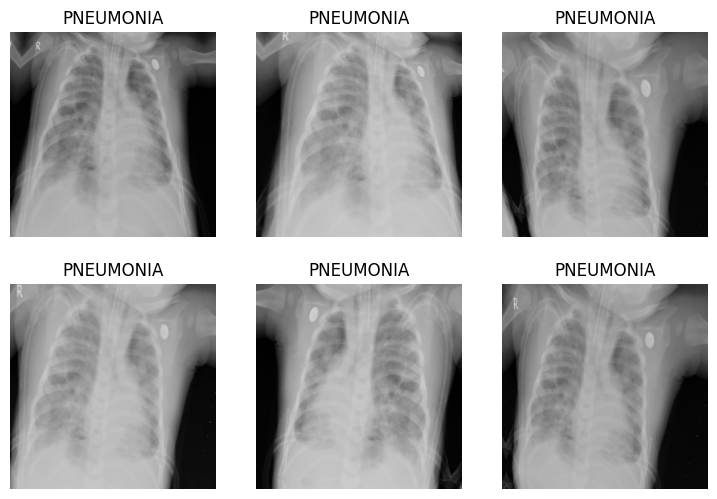

In [19]:
tfms = [
    Resize(256, method='squish'),
    *aug_transforms(
        mult=1.0,
        do_flip=True,
        flip_vert=False,
        max_rotate=10.0,
        min_zoom=1.0,
        max_zoom=1.1,
        max_lighting=0.2,
        max_warp=0.2,
        p_affine=0.75,
        p_lighting=0.75
    ),  # Apply random augmentations
    Normalize.from_stats(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
]


dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')],
    batch_tfms=tfms
).dataloaders(IMAGES_PATH, bs=64)

dls.show_batch(max_n=6, unique=True)

In [ ]:
learn = vision_learner(dls, convnext_tiny, metrics=accuracy)
learn.fine_tune(3, freeze_epochs=1)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

In [ ]:
interp.plot_top_losses(8, figsize=(13,13))